In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
sns.set_palette("bright")

## Introduction

The Singapore dollar (SGD) was tied to the US dollar (USD) from 1967 to 1973. This pegging was established shortly after Singapore gained independence in 1965 and was part of the broader Bretton Woods system of fixed exchange rates, which was in effect until its collapse in 1971. Under this system, the value of the SGD was fixed against the USD at a rate of 2.40 SGD to 1 USD. However, in 1973, Singapore moved away from this fixed exchange rate system and adopted a managed float regime, allowing the SGD to be determined by market forces with periodic interventions by the Monetary Authority of Singapore (MAS) to stabilize the currency. Currently, MAS manages the SGD against a basket of currencies of Singapore's major trading partners and competitors, rather than just one currency like the USD.

Given, the robust trade relations and capital flows between US and Singapore, it would be interesting to find out how the interest rates of the US affects the interest rates of Singapore. 

In this project, we will use the Secured Overnight Financing Rate (SOFR) and the Singapore Overnight Rate Average (SORA) to compare the effective interest rates of the US and Singapore respectively. While these rates are not the exact interest rates published/given by the monetary authorities of each country, they represent the benchmark overnight rate of the market. We should expect a high pass-through between these rates and the policy rates [gellert2021short].

Historically, the effective interest rates of US and Singapore could be tracked using the USD London Interbank Offered Rate (LIBOR) and Singapore Interbank Offered Rate (SIBOR). They have been discontinued since 2018 as the -IBOR rates is based on the submissions of agreed upon borrowing rates between major banks. Meanwhile, the SOFR and SORA represent actual overnight transactions that occured making it more transparent to the public. Therefore, data sourced for these rates only start from April 2018 onwards. 

The data was sourced from the Federal Reserve Bank of NY (for SOFR) and the MAS (for SORA) websites. As public holidays of Singapore and the US do not line up, missing entries of the dates due to misaligned public holidays had data imputed from the previous day's rate. Rate over the weekend were not captured. The Rates are captured from April 2018 to December 2023.

@misc{gellert2021short,
      title={Short Rate Dynamics: A Fed Funds and SOFR perspective}, 
      author={Karol Gellert and Erik Schlögl},
      year={2021},
      eprint={2101.04308},
      archivePrefix={arXiv},
      primaryClass={q-fin.MF}
}

## Method

In [22]:
# Read in the data.csv file
df = pd.read_csv('data.csv')

# Combine Year, Month, and Day into a single column
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

print(df.head())

   Year  Month  Day  SOFR Rate  SORA Rate       date
0  2018      4    2       1.80     0.6773 2018-04-02
1  2018      4    3       1.83     0.5953 2018-04-03
2  2018      4    4       1.74     0.4255 2018-04-04
3  2018      4    5       1.75     0.1524 2018-04-05
4  2018      4    6       1.75     0.1727 2018-04-06


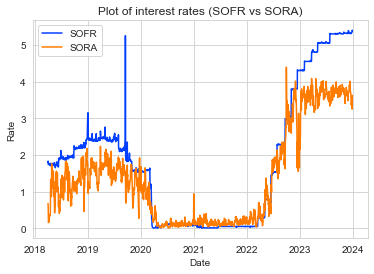

In [23]:
# Graph SOFR, SORA
plt.plot(df['date'], df['SOFR Rate'], label='SOFR')
plt.plot(df['date'], df['SORA Rate'], label='SORA')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Plot of interest rates (SOFR vs SORA)')
plt.legend()
plt.show()

In [24]:
# Calculate spearman rank correlation
spearman_corr = df[['SOFR Rate', 'SORA Rate']].corr(method='spearman')
print(spearman_corr)

           SOFR Rate  SORA Rate
SOFR Rate   1.000000   0.905059
SORA Rate   0.905059   1.000000


It is observed that the SOFR and SORA closely follow each other and is strongly correlated using the Spearman's coefficient. However, it seems that the SOFR is almost always lies above the SORA. 

## Relating both series and dimensionality reduction

Assuming the two time series are linked, the covariance matrix of the two time series represents the degree of linear relationship between SORA and SOFR. The magnitude of the covariance represents the strength of the relationship. Before we compute the covariance matrix, we shall check the time series to check for stationarity.

Non-stationarity is calculated using the Augmented Dickey-Fuller (ADF) test to statistically assess for a unit root within the dataset. The presence of a unit root indicates a clear trend and inconsistent mean and variance [cheung1995lag].

article{cheung1995lag,
  title={Lag order and critical values of the augmented Dickey--Fuller test},
  author={Cheung, Yin-Wong and Lai, Kon S},
  journal={Journal of Business \& Economic Statistics},
  volume={13},
  number={3},
  pages={277--280},
  year={1995},
  publisher={Taylor \& Francis Group}
}

In [25]:
# Check for stationarity
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

check_for_stationarity(df['SOFR Rate'])
check_for_stationarity(df['SORA Rate'])

p-value = 0.9925058004520207 The series SOFR Rate is likely non-stationary.
p-value = 0.9520867828540598 The series SORA Rate is likely non-stationary.


False

We are unable to compute the covariance matrix of the SOFR and SORA directly due to both series being non-stationarity. Computing the covariance matrix directly violates the assumptions of the calculations as the normal cross sectional assumptions is for the two random variables to be independent and identically distributed (iid). To compute the covariance matrix, we integrate both series to get their first difference, I(1) series.

In [26]:
# Integrate both series via first time differences
df['sora_diff'] = df['SORA Rate'].diff()
df['sofr_diff'] = df['SOFR Rate'].diff()

# Check for stationarity again
check_for_stationarity(df['sofr_diff'].dropna())
check_for_stationarity(df['sora_diff'].dropna())

p-value = 1.5365451115260095e-26 The series sofr_diff is likely stationary.
p-value = 1.4458538638349126e-22 The series sora_diff is likely stationary.


True

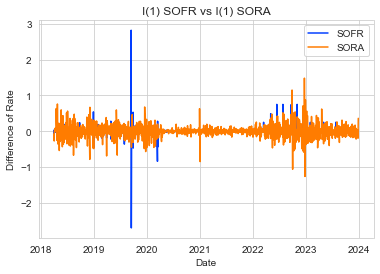

In [27]:
# Plot the differenced series
plt.plot(df['date'], df['sofr_diff'], label='SOFR')
plt.plot(df['date'], df['sora_diff'], label='SORA')
plt.xlabel('Date')
plt.ylabel('Difference of Rate')
plt.title('I(1) SOFR vs I(1) SORA')
plt.legend()

Now that the series are stationary, we can find the covariance matrix of the I(1) series for SORA and SOFR.

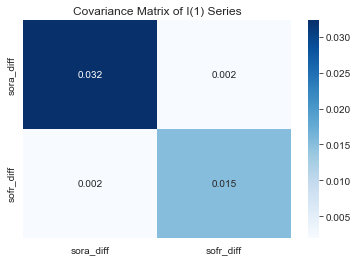

In [28]:
# Obtain covariance matrix
cov_matrix = df[['sora_diff', 'sofr_diff']].cov()
sns.heatmap(cov_matrix, annot=True, cmap='Blues')
plt.title('Covariance Matrix of I(1) Series')
plt.show()

In [29]:
# PCA on covariance matrix
eig_values, eig_vectors = np.linalg.eig(cov_matrix)
print(eig_values)
print(eig_vectors)

[0.03254594 0.01487392]
[[ 0.99362187 -0.11276334]
 [ 0.11276334  0.99362187]]


As expected, we do not obtain much useful information when trying to reduce the dimensionality of this covariance matrix. Reducing the dimensions of this matrix returns eigenvectors of almost [1,0] and [0,1]. This means that the underlying data is already along the principal components.

However, from the covariance matrix, it is clear that the I(1) of the series does not have a distinct linear relationship with each other. More cointegration studies can be conducted on this in the future. Non-linear studies can also be conducted on the I(0) series themselves to study more about their relationship.

## Predict

While it is illogical to predict these rates as they are determined by decisions and policies in the central banks, we attempt to predict how close these rates track each other.

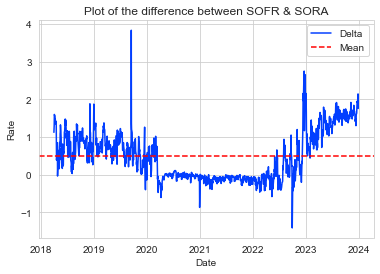

In [30]:
# Delta between SOFR and SORA
df['delta'] = df['SOFR Rate'] - df['SORA Rate']

# Graph the delta
m = df['delta'].mean()

plt.plot(df['date'], df['delta'])
plt.axhline(m, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Plot of the difference between SOFR & SORA')
plt.legend(['Delta', 'Mean'])
plt.show()

In [31]:
check_for_stationarity(df['delta'])

p-value = 0.49816051299486236 The series delta is likely non-stationary.


False

In a non-stationary graph, the pattern or trend of the data changes over time or across different segments of the graph. This means that the relationship between the variables depicted in the graph is not consistent throughout. Instead, it fluctuates or varies, indicating that there are underlying factors causing the data to behave differently at different points or periods. It is observed that the SORA, SOFR and the delta between them are all non-stationary.

Perhaps a better way of measuring the difference between the series' is using a percentage difference. As we are trying to identify the system driving the effect of US rates on Singaporean rates, we define the percentage difference of the rates over the SORA.

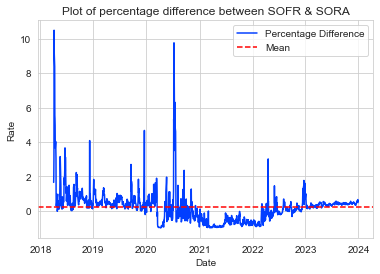

In [32]:
# Percentage difference between SOFR and SORA
df['delta_pct'] = (df['SOFR Rate'] - df['SORA Rate']) / df['SORA Rate']

# Graph the percentage difference
m = df['delta_pct'].mean()

plt.plot(df['date'], df['delta_pct'])
plt.axhline(m, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Plot of percentage difference between SOFR & SORA')
plt.legend(['Percentage Difference', 'Mean'])
plt.show()

In [33]:
# Check for stationarity
check_for_stationarity(df['delta_pct'])


p-value = 3.3003920219506817e-07 The series delta_pct is likely stationary.


True

  0%|          | 0/21 [00:00<?, ?it/s]

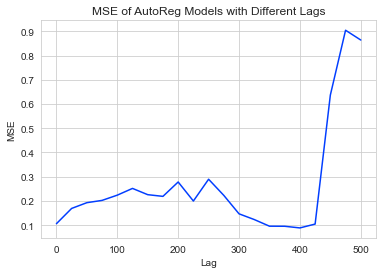

In [34]:
# Predict delta percentage using AR model
# Split data into training and testing (80,20)
train = df['delta_pct'][:int(0.8*(len(df['delta_pct'])))]
test = df['delta_pct'][int(0.8*(len(df['delta_pct']))):]

# MSE Loss
def calculate_mse(actual, predicted):
    return mean_squared_error(actual, predicted)

mse_values = []
iterator = range(0, 501, 25)

# Loop over lags
for lag in tqdm(iterator):
    # Fit AutoReg model
    model = AutoReg(train, lags=lag)
    model_fit = model.fit()
    # Predict
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
    # Calculate and store MSE
    mse = calculate_mse(test, predictions)
    mse_values.append(mse)

# Plot MSE values
plt.plot(iterator, mse_values)
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.title('MSE of AutoReg Models with Different Lags')
plt.show()

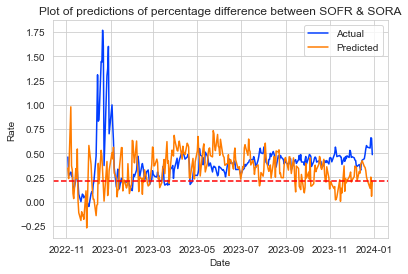

In [35]:
# Best lag=400
model = AutoReg(train, lags=400)
model_fit = model.fit()

# Predict
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Baseline model using mean of delta_pct
predicted_sora_baseline = []
delta_pct_mean = df['delta_pct'].mean()
index = 1176
for pred in predictions:
    predicted_sora_baseline.append(df['SOFR Rate'][int(index)] / (delta_pct_mean + 1))
    index += 1

# Plot the predictions
plt.plot(df['date'][int(0.8*(len(df['delta_pct']))):], test, label='Actual')
plt.plot(df['date'][int(0.8*(len(df['delta_pct']))):], predictions, label='Predicted')
plt.axhline(delta_pct_mean, color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Plot of predictions of percentage difference between SOFR & SORA')
plt.legend()


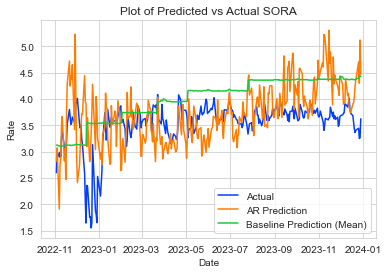

MSE (Baseline):  0.409075542764802
MSE (AR):  0.4356345592702206


In [36]:
# Predicting SORA using SOFR
predicted_sora = []
index = 1176

for pred in predictions:
    predicted_sora.append(df['SOFR Rate'][int(index)] / (pred + 1))
    index += 1


# Plot the predictions
plt.plot(df['date'][int(0.8*(len(df['delta_pct']))):], df['SORA Rate'][int(0.8*(len(df['delta_pct']))):], label='Actual')
plt.plot(df['date'][int(0.8*(len(df['delta_pct']))):], predicted_sora, label='AR Prediction')
plt.plot(df['date'][int(0.8*(len(df['delta_pct']))):], predicted_sora_baseline, label='Baseline Prediction (Mean)')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Plot of Predicted vs Actual SORA')
plt.legend()
plt.show()

# Calculate MSE
print('MSE (Baseline): ', calculate_mse(df['SORA Rate'][int(0.8*(len(df['delta_pct']))):], predicted_sora_baseline))
print('MSE (AR): ', calculate_mse(df['SORA Rate'][int(0.8*(len(df['delta_pct']))):], predicted_sora))

From the results above, we are comparing the AR(400) model to the baseline model of the mean of the percentage difference between SOFR and SORA. The AR(400) model has the lowest MSE of all the AR models tested. Despite it being the best AR model, using the mean of the percentage difference to predict SORA turns out to provide an even lower MSE than the AR model. However, the AR model seems to have a lower bias but a much higher variance compared to the baseline model. The AR model may be overfitting the dataset. Given that we are working on stationary data, it actually may be better to predict future data using a linear regression (mean) instead!